In [1]:
import theano
import tensorflow
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn import preprocessing

from sklearn.metrics import confusion_matrix,classification_report, accuracy_score

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
filename = '../../Dataset/heartbeatFeaturesA4.csv'
df = pd.read_csv(filename)

# Remove the extra column read

toremove = df.shape[1] -1 
df = df.iloc[:, 0:toremove]
df.head()

,stdPCA1,stdPCA2,stdPCA3,meanPCA1,meanPCA2,meanPCA3,meanS1,meanS2,stdS1,stdS2,...,minstdS1,maxstdS1,mmstdS1,minstdS2,maxstdS2,mmstdS2,posRatio,stdWavelet,meanWavelet,class
0,2.443969,1.956057,1.419750,-1.130227e-16,2.300462e-17,-3.150633e-17,630.9091,775.6364,27.21196,84.00985,...,23.28590,23.73020,19.31608,62.78225,79.19042,56.28153,0.260870,0.063271,0.006662,Normal
1,3.258185,1.120398,0.830715,-1.528407e-16,-4.200344e-17,5.618962e-17,2118.5000,2387.6670,258.09400,781.68690,...,258.09400,258.09400,258.09400,943.28040,27.57716,781.68690,0.666667,0.210681,0.006673,Normal
2,2.647761,1.797890,1.190613,-1.489627e-16,8.707632e-18,-5.675510e-18,1584.6670,1601.0000,445.91960,193.08370,...,511.94530,62.93250,445.91960,210.90600,50.29248,55.15433,0.250000,0.122422,-0.003863,Normal
3,2.767485,1.699618,1.107745,7.495414e-17,-2.916449e-17,-3.437746e-17,500.1667,687.0000,41.92381,37.17257,...,38.70518,38.58568,35.38503,34.71087,31.92091,29.30491,0.583333,0.516152,0.039785,Normal
4,2.381787,1.941468,1.482395,2.343804e-17,3.225815e-17,-4.268191e-17,601.9000,928.0909,46.01075,37.85883,...,37.46925,46.21087,37.83965,36.80957,31.54697,30.47039,0.000000,0.040477,0.001033,Normal


# Some nice stats

In [5]:
# Check the Dimensions of the data

df.shape

(124, 27)

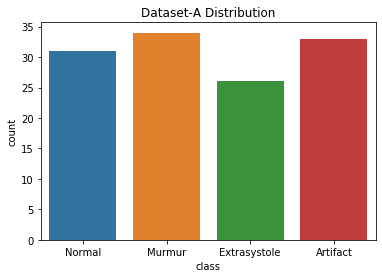

In [6]:
# Check the sitribution of the dataset

plot = sns.countplot(x='class', data=df).set_title('Dataset-A Distribution')

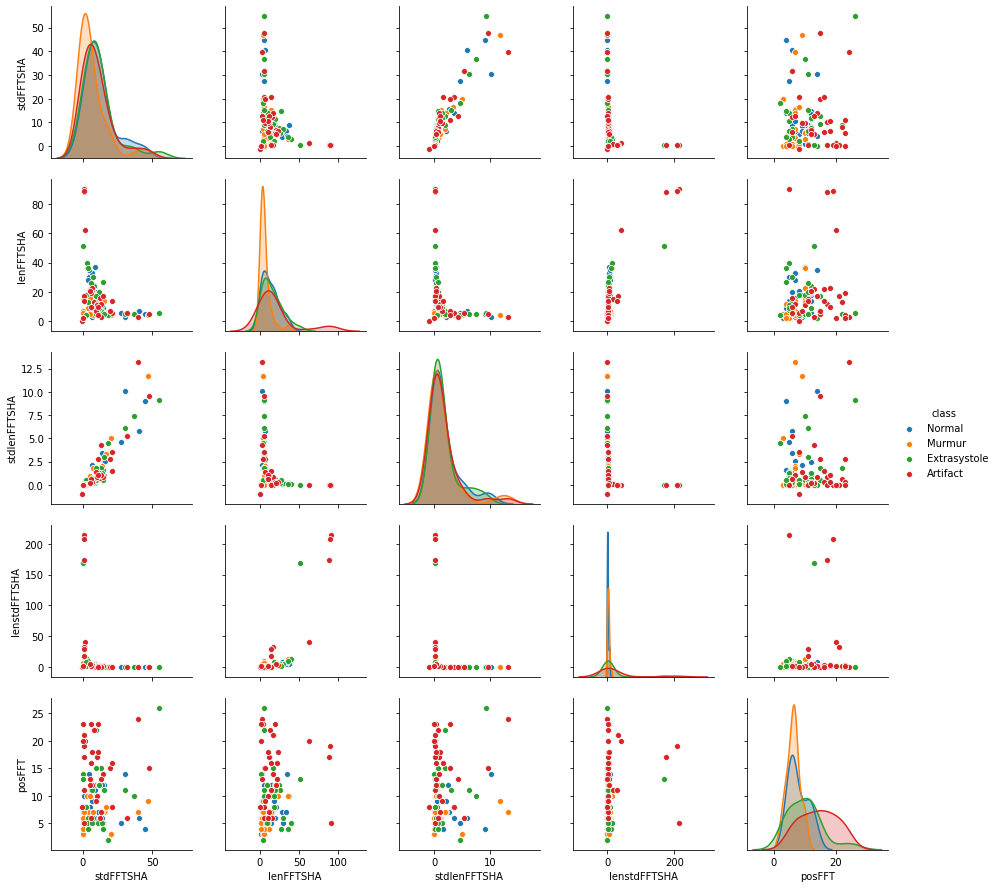

In [7]:
# Check some relationships of the different features

sns.pairplot(df, vars=df.columns[12:17], hue='class')

## Back to the real stuff - Conditioning the Data

In [8]:
# Only take this select set of features from the Dataset A

X = df.iloc[:,0:17]
X[['maxstdS1', 'maxstdS2', 'mmstdS1', 'mmstdS2']] = df[['maxstdS1', 'maxstdS2','mmstdS1', 'mmstdS2']]

# Normalise the features

min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(X)
X = pd.DataFrame(x_scaled)
X.head()

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,0.319128,0.725107,0.834288,0.525408,0.563569,0.483254,0.136398,0.030223,0.013630,0.008166,...,0.471032,0.149668,0.200000,0.099185,0.011421,0.416667,0.016788,0.007698,0.013665,0.005471
1,0.930489,0.080488,0.288644,0.511140,0.508514,0.600222,0.693966,0.126579,0.129271,0.075983,...,0.553571,0.175355,0.222222,0.101356,0.010620,0.375000,0.182591,0.002681,0.182591,0.075983
2,0.472147,0.603098,0.622030,0.512529,0.551461,0.517707,0.493878,0.079558,0.223347,0.018768,...,0.531235,0.096125,0.333333,0.080668,0.032069,0.125000,0.044522,0.004889,0.315471,0.005361
3,0.562043,0.527292,0.545267,0.592769,0.519388,0.479424,0.087394,0.024925,0.020998,0.003613,...,0.720608,0.111594,0.233333,0.087953,0.018741,0.250000,0.027298,0.003103,0.025034,0.002849
4,0.272438,0.713853,0.892318,0.574308,0.571406,0.468348,0.125525,0.039336,0.023045,0.003680,...,0.339286,0.562892,0.033333,0.784206,0.000460,0.500000,0.032692,0.003066,0.026770,0.002962


In [9]:
# For testing later on ....
P = X.values[15:22,:]

In [10]:
# Get the classes

y = df.iloc[:,toremove-1:toremove]
y.head()

Y = pd.get_dummies(y['class'])
print(Y)

     Artifact  Extrasystole  Murmur  Normal
0           0             0       0       1
1           0             0       0       1
2           0             0       0       1
3           0             0       0       1
4           0             0       0       1
..        ...           ...     ...     ...
119         1             0       0       0
120         1             0       0       0
121         1             0       0       0
122         1             0       0       0
123         1             0       0       0

[124 rows x 4 columns]


In [11]:
# Randomise the dataset

X,Y = shuffle(X,Y,random_state=100)

In [13]:
X.head()

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
11,0.197452,0.934159,0.751338,0.552400,0.457282,0.397901,0.215392,0.035445,0.206511,0.028875,...,0.207125,0.017923,0.022222,0.070426,0.009328,0.166667,0.076183,0.030322,0.073149,0.009679
107,0.672877,0.546686,0.426881,0.525241,0.450272,1.000000,0.094228,0.025882,0.292179,0.057793,...,0.160714,0.246050,0.033333,0.369217,0.001099,0.458333,0.062177,0.020489,0.018802,0.020370
102,0.891815,0.182362,0.280085,0.585271,0.328197,0.469129,0.038451,0.008000,0.051915,0.011963,...,0.625000,0.191604,0.077778,0.167917,0.003369,0.291667,0.064311,0.009226,0.061593,0.009216
70,0.289530,0.972174,0.576681,0.619692,0.636528,0.430919,0.069238,0.013286,0.043519,0.012704,...,0.621026,0.678741,0.055556,0.589734,0.000633,0.333333,0.059113,0.008147,0.051617,0.008101
85,0.847793,0.428626,0.000000,0.764831,0.830965,0.849410,0.129535,0.041811,0.113535,0.121109,...,0.125000,0.060181,0.200000,0.079651,0.035608,0.250000,0.153930,0.007504,0.083924,0.008592


In [14]:
# Split into training & Testing

from sklearn.model_selection import train_test_split
X_train,X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.2, random_state = 100)


In [16]:
# Check the proportions of classes for training

classes, count = np.unique(Y_train,axis=0,return_counts=True)

print(classes,'\n')
print("Training numbers : ",count, '\n')

[[0 0 0 1]
 [0 0 1 0]
 [0 1 0 0]
 [1 0 0 0]] 

Training numbers :  [26 25 20 28] 



In [17]:
# Check the proportions of classes for testing

classes, count = np.unique(Y_test,axis=0,return_counts=True)

print(classes,'\n')
print("Training numbers : ",count, '\n')

[[0 0 0 1]
 [0 0 1 0]
 [0 1 0 0]
 [1 0 0 0]] 

Training numbers :  [5 9 6 5] 



# Training

In [18]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers.core import Dropout
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam

Using TensorFlow backend.


In [19]:
# Use sequential model
clf = Sequential()

W0913 00:16:58.294759 139720279684928 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.



In [20]:
# Get dimension of the model from the dataset

x_dim = X.shape[1]
y_dim = Y.shape[1]

n_unit = int(np.floor((x_dim + y_dim)/2))

print(x_dim, y_dim,n_unit)

21 4 12


In [21]:
# Build the model

clf.add(Dense(activation = 'relu', input_dim = x_dim, units=n_unit, kernel_initializer= 'uniform'))
#clf.add(Dropout(0.25))

W0913 00:18:34.845509 139720279684928 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0913 00:18:35.188326 139720279684928 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



In [22]:
# Only use one hidden layer

layers = 1
clf.add(Dense(activation= 'relu', units = n_unit, kernel_initializer='uniform'))

In [23]:
# Adding the output layer

clf.add(Dense(activation = 'softmax', units=y_dim, kernel_initializer='uniform'))

In [24]:
# Finalise the model

clf.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=['accuracy'])

W0913 00:20:18.828554 139720279684928 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0913 00:20:18.904931 139720279684928 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/dist-packages/keras/backend/tensorflow_backend.py:3376: The name tf.log is deprecated. Please use tf.math.log instead.

W0913 00:20:18.915727 139720279684928 deprecation.py:323] From /usr/local/lib/python3.7/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [25]:
# Start training

history = clf.fit(X_train, Y_train, batch_size=10, epochs=100, 
validation_data=(X_test, Y_test)  ,shuffle=True)

#validation_data=(X_test, Y_test) validation_split=0.2 

W0913 00:20:57.764626 139720279684928 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 99 samples, validate on 25 samples
Epoch 1/100
99/99 [==============================] - 1s 15ms/step - loss: 0.5624 - acc: 0.7500 - val_loss: 0.5625 - val_acc: 0.7500
Epoch 2/100
99/99 [==============================] - 0s 308us/step - loss: 0.5622 - acc: 0.7500 - val_loss: 0.5625 - val_acc: 0.7500
Epoch 3/100
99/99 [==============================] - 0s 197us/step - loss: 0.5620 - acc: 0.7500 - val_loss: 0.5624 - val_acc: 0.7500
Epoch 4/100
99/99 [==============================] - 0s 206us/step - loss: 0.5618 - acc: 0.7500 - val_loss: 0.5623 - val_acc: 0.7500
Epoch 5/100
99/99 [==============================] - 0s 167us/step - loss: 0.5617 - acc: 0.7500 - val_loss: 0.5622 - val_acc: 0.7500
Epoch 6/100
99/99 [==============================] - 0s 186us/step - loss: 0.5614 - acc: 0.7500 - val_loss: 0.5618 - val_acc: 0.7500
Epoch 7/100
99/99 [==============================] - 0s 240us/step - loss: 0.5610 - acc: 0.7500 - val_loss: 0.5616 - val_acc: 0.7500
Epoch 8/100
99/99 [=======

Epoch 62/100
99/99 [==============================] - 0s 183us/step - loss: 0.3919 - acc: 0.8258 - val_loss: 0.4407 - val_acc: 0.7900
Epoch 63/100
99/99 [==============================] - 0s 221us/step - loss: 0.3912 - acc: 0.8258 - val_loss: 0.4392 - val_acc: 0.7900
Epoch 64/100
99/99 [==============================] - 0s 175us/step - loss: 0.3909 - acc: 0.8232 - val_loss: 0.4413 - val_acc: 0.8000
Epoch 65/100
99/99 [==============================] - 0s 186us/step - loss: 0.3918 - acc: 0.8232 - val_loss: 0.4378 - val_acc: 0.7900
Epoch 66/100
99/99 [==============================] - 0s 176us/step - loss: 0.3893 - acc: 0.8258 - val_loss: 0.4390 - val_acc: 0.8000
Epoch 67/100
99/99 [==============================] - 0s 183us/step - loss: 0.3880 - acc: 0.8232 - val_loss: 0.4366 - val_acc: 0.8000
Epoch 68/100
99/99 [==============================] - 0s 169us/step - loss: 0.3882 - acc: 0.8258 - val_loss: 0.4360 - val_acc: 0.7900
Epoch 69/100
99/99 [==============================] - 0s 174us

### Plots

Text(0.5, 1.0, 'Training and Validation Loss for Dataset A')

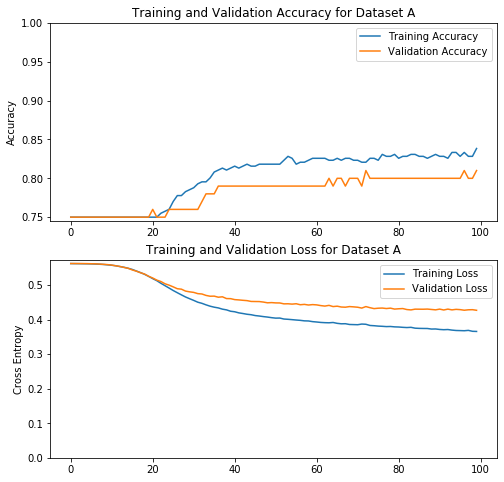

In [26]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='upper right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy for Dataset A')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss for Dataset A')
# figure_name = './Models/A_81_83_Dropout_25_Validation_split_lr_0_1'
# plt.savefig(figure_name + '.jpg')
# plt.savefig(figure_name + '.png')

In [27]:
print('Final Accuracy: ' ,val_acc[99]*100, '\tMean Accuracy :', np.mean(val_acc)*100, '\n\nTraining Accuracy: ', acc[99]*100 ,'\tMean Training Accuracy :', np.mean(acc)*100, )

Final Accuracy:  80.99999904632568 	Mean Accuracy : 78.13000016212462 

Training Accuracy:  83.83838347714357 	Mean Training Accuracy : 80.17929295217148


# Testing 123 Testing

In [28]:
Y_pred = clf.predict(X_test)

In [29]:
for i in range (0,Y_pred.shape[0]):
  Y_pred[i] = (Y_pred[i] == np.max(Y_pred[i]))


In [30]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test.values.argmax(axis=1),Y_pred.argmax(axis=1))
print(cm)

[[3 1 0 1]
 [1 2 0 3]
 [0 0 6 3]
 [0 0 1 4]]


In [31]:
score = accuracy_score(Y_test.values.argmax(axis=1),Y_pred.argmax(axis=1))
print(score)

0.6


In [32]:
print(classification_report(Y_test.values.argmax(axis=1),Y_pred.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.75      0.60      0.67         5
           1       0.67      0.33      0.44         6
           2       0.86      0.67      0.75         9
           3       0.36      0.80      0.50         5

    accuracy                           0.60        25
   macro avg       0.66      0.60      0.59        25
weighted avg       0.69      0.60      0.61        25



In [34]:
# This is  the log file ....
#with open('./Logs/A_ANN_stats.log', 'a+') as f:
#           f.write('\n==============================================================\n' + '\n '+ filename  +'\n\n' + str(cm) +'\n\n' + 'Dimensions: ' + str(x_dim) +' Layers: ' + str(layers) + '\n'+ 'Testing Accuracy: ' + str(val_acc[99]*100) + ' Training Acc: ' + str(acc[99]*100) + '\nTesting Score: '+ str(score) + '\n\n' + classification_report(Y_test.values.argmax(axis=1),Y_pred.argmax(axis=1)))

# Saving The Model


In [33]:
# import pickle

In [34]:
# model_name_ = '../../Models/ANN_DatasetA_81_83_Dropout_25_Validation_split_lr_0_1v3'
# model = open(model_name_ + '.pkl', "wb")
# pickle.dump(clf,model)
# model_pkl = open(model_name_ + '.pkl', "rb")
# model_test = pickle.load(model_pkl)
# model_test.summary()

In [35]:
#  model_test.predict_proba(P)

# Another way of Saving

In [36]:

# clf.save(model_name_ + '.h5')
# new_model = keras.models.load_model(model_name_ + '.h5')
# new_model.summary()

In [40]:
# new_predictions = new_model.predict(P)
# print(new_predictions )